In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
from datasets import SinusoidDataset
from models import MLPCNF
from lightning import Trainer
from lightning.pytorch.callbacks import RichModelSummary

In [3]:
dataset = SinusoidDataset()
model = MLPCNF(
    dim=3,
    obs_dim=len(dataset.observation_times),
    hidden_dim=512,
    depth=8,
    lr=1e-4,
)
# model = torch.compile(model)

train_dataloader = dataset.dataloader(
    batch_size=1024,
    batches=1024,
    num_workers=128,
    persistent_workers=True,
    pin_memory=True,
)
trainer = Trainer(
    #accelerator="cpu",
    devices="0,",
    max_epochs=10,
    callbacks=[RichModelSummary()],
)
trainer.fit(model, train_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


┏━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ flow │ MLP  │  1.9 M │
└───┴──────┴──────┴────────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/5 [00:00<?, ?it/s]

Pushing data through flow


100%|██████████| 16/16 [00:00<00:00, 2354.28it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 75.26it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 79.02it/s]


Pushing data through flow


100%|██████████| 16/16 [00:00<00:00, 2260.93it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 76.34it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 78.21it/s]


Pushing data through flow


100%|██████████| 16/16 [00:00<00:00, 1833.73it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 76.07it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 75.94it/s]


Pushing data through flow


100%|██████████| 16/16 [00:00<00:00, 2338.70it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:04<00:00, 74.51it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 74.07it/s]


Pushing data through flow


100%|██████████| 16/16 [00:00<00:00, 2336.25it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 76.40it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 75.52it/s]


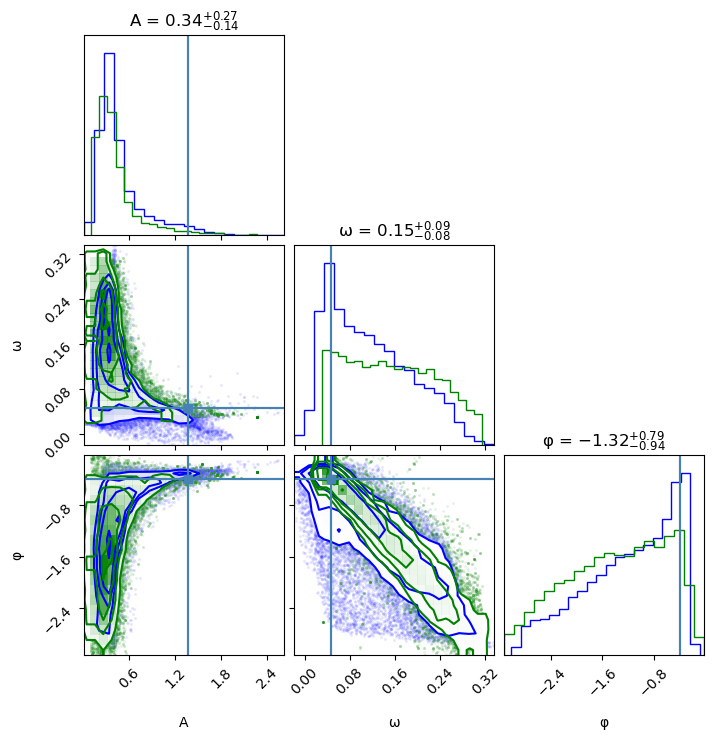

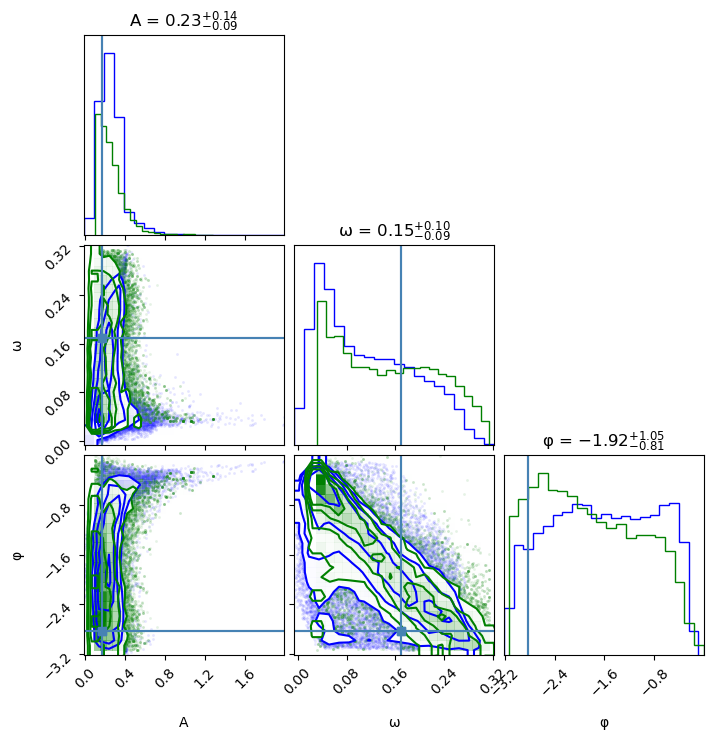

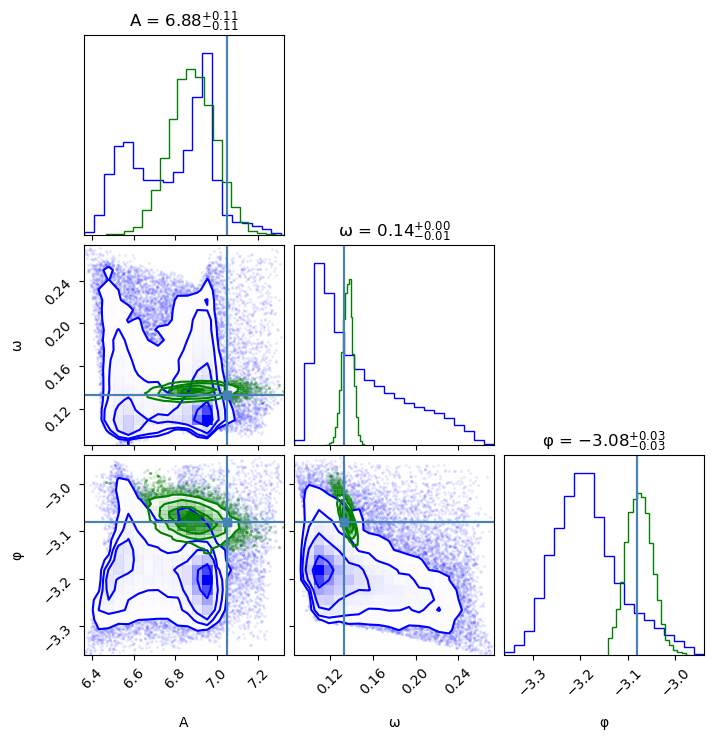

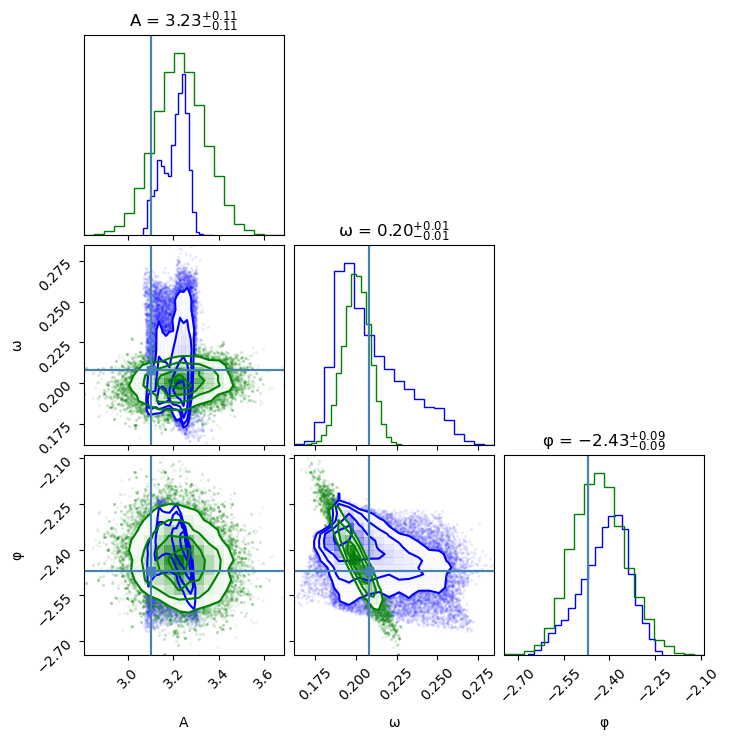

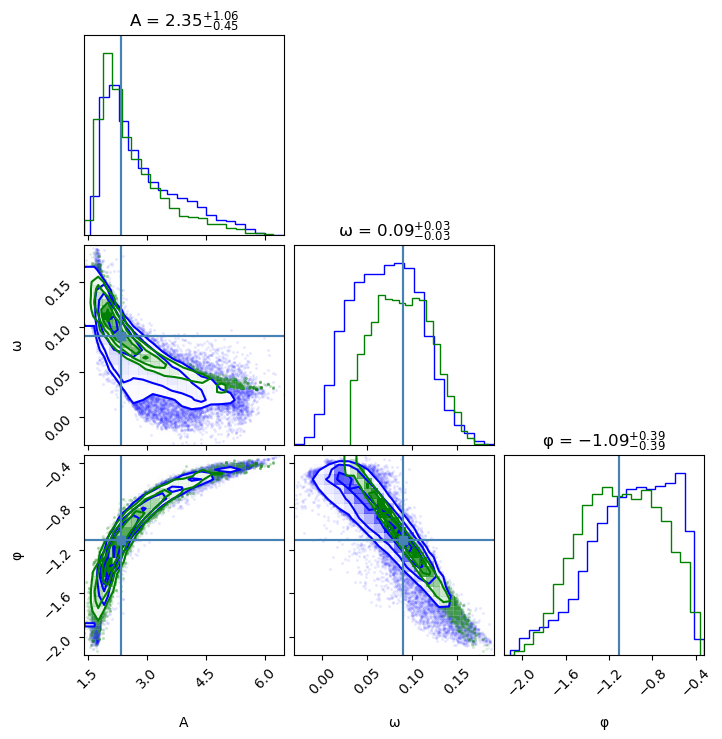

In [5]:
from utils import corner_plot
corner_plot(dataset, model.to("cuda"), examples=5, ode_steps=16, samples=32*1024, verbose=True)